<a href="https://colab.research.google.com/github/lcipolina/escher/blob/master/ML/Taming_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is inspired by the original colab notebook [here](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). Using [Weights and Biases](https://wandb.ai/site) we can keep tab of the results generated and even download them conveniently. 

# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.



In [1]:
# install W&B
!pip install wandb -q

# Install pytorch-lightning
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

# Clone taming transformer repo
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

# download the checkpoints
!mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'

# download the configs
!mkdir logs/2020-11-09T13-31-51_sflckr/configs
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-uqib6u1d
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-uqib6u1d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.3.0.dev0-cp37-none-any.whl size=827690 sha256=276c06f9169eb3c68fa8532e1e43a0a68b1e5f732d35bb6187eb65866b8cba24
  Stored in directory: /tmp/pip-ephem-wheel-cache-oko3255t/wheels/e2/c6/88/caa5d4cfbfab631fc84b0107896a6f661a1caf589160c27e71
Successfully built pytorch-lightning
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/content/taming-transformers
--2021-03-17 15:08:32--  https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Co

Next, we install minimal required dependencies.

In [2]:
%%capture
%pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
import sys
sys.path.append(".")

## Imports

In [3]:
import os
import yaml
import glob

import torch
import numpy as np
from PIL import Image

#LUCIA
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning fsspec --no-deps --target=$nb_path 

from omegaconf import OmegaConf
from taming.models.cond_transformer import Net2NetTransformer

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-ac75g5iw
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-ac75g5iw
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.3.0.dev0-cp37-none-any.whl size=827690 sha256=6ee5c3a4c189f80e87a91e03cb5f6328ad18125e96a1033aaece43e2d4539884
  Stored in directory: /tmp/pip-ephem-wheel-cache-rl2wlbcq/wheels/e2/c6/88/caa5d4cfbfab631fc84b0107896a6f661a1caf589160c27e71
Successfully built pytorch-lightning
  Found existing installation: pytorch-lightning 1.0.8
    Uninstalling pytorch-lightning-1.0.8:
      Successfully uninstalled pytorch-lightning-1.0.8


## W&B Setup

* Create an account on [https://wandb.ai](https://wandb.ai) (it's free)
* Install wandb
* Input your personal key of the project.

In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load the Configuration file

Load and print the config.

In [5]:
config_path = "logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
config = OmegaConf.load(config_path)

print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

## Loading the model

Instantiate the model.

In [6]:
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Load the checkpoint.

In [7]:
ckpt_path = "logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [8]:
model.cuda().eval()
torch.set_grad_enabled(False)

# Start Taiming Transformer

## I. Initialize W&B run

In [9]:
run = wandb.init(project="taming-transformer", job_type='inference')

wandb: Currently logged in as: lcipolina (use `wandb login --relogin` to force relogin)


## II. Load example data

Load an example segmentation and visualize. Move the slider to select one of 25 example images. Here segmentation mask is used as a conditional information.

In [10]:
segmentation_paths = glob.glob('data/sflckr_segmentations/*/*')
index = 6 #@param {type:"slider", min:0, max:25, step:1}
segmentation_path = segmentation_paths[index]

segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
segmentation = np.eye(182)[segmentation]
segmentation = torch.tensor(segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

Visualize

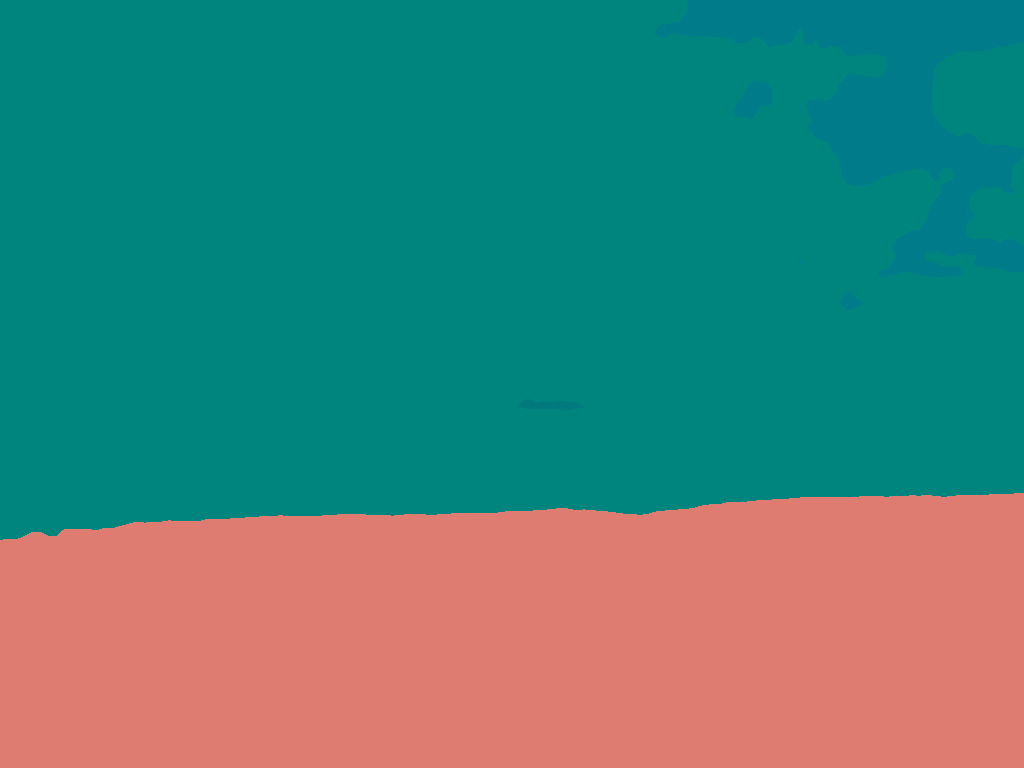

In [11]:
def show_segmentation(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  colorize = np.random.RandomState(1).randn(1,1,s.shape[-1],3)
  colorize = colorize / colorize.sum(axis=2, keepdims=True)
  s = s@colorize
  s = s[...,0,:]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  img = Image.fromarray(s)
  display(img)
  return s

s = show_segmentation(segmentation)
wandb.log({'segmentation mask': [wandb.Image(s, caption="Segmentation Mask as Conditional Information")]})

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

c_code torch.Size([1, 256, 48, 64]) torch.float32
c_indices torch.Size([1, 3072]) torch.int64
Note the change in dtype from float32 to int64. Quantized!


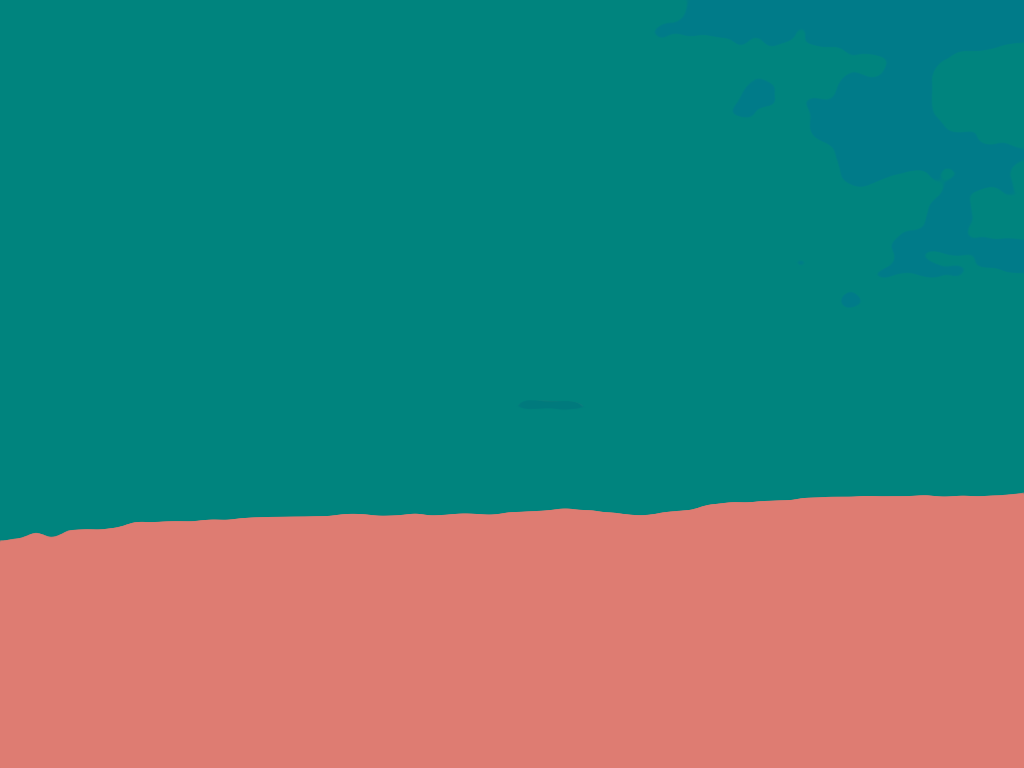

In [12]:
# get the latent code conditioned on the segmentation mask. 
c_code, c_indices = model.encode_to_c(segmentation)
print("c_code", c_code.shape, c_code.dtype)
print("c_indices", c_indices.shape, c_indices.dtype)
print("Note the change in dtype from float32 to int64. Quantized!")
assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[1]

segmentation_rec = model.cond_stage_model.decode(c_code)
_ = show_segmentation(torch.softmax(segmentation_rec, dim=1))

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

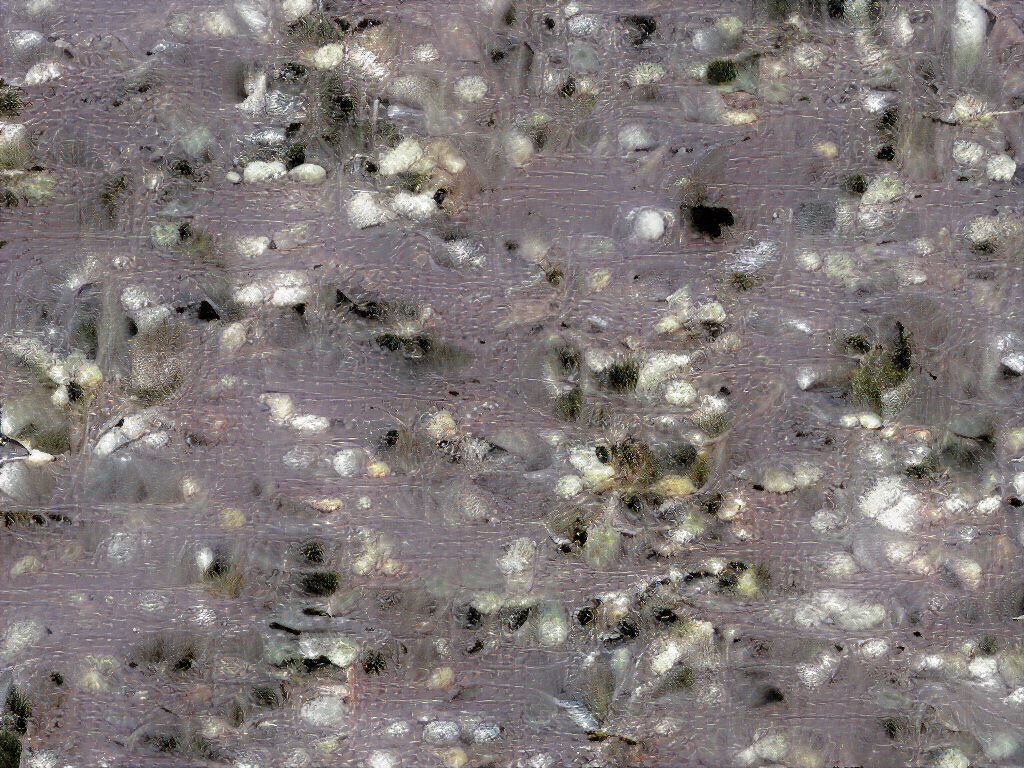

In [13]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  img = Image.fromarray(s)
  display(img)
  return s

codebook_size = config.model.params.first_stage_config.params.embed_dim
z_indices_shape = c_indices.shape
z_code_shape = c_code.shape
z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
_ = show_image(x_sample)

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

Time: 466.7287962436676 seconds
Step: (47,63) | Local: (15,15) | Crop: (32:48,48:64)


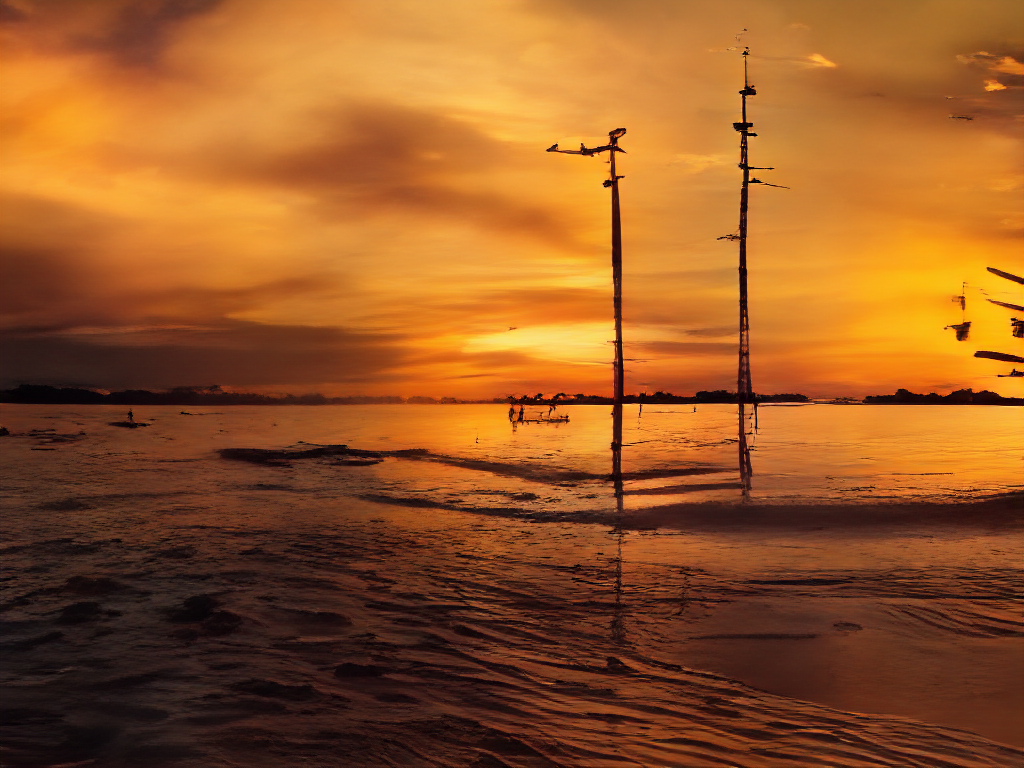

_runtime,565
_timestamp,1615995116
_step,63


_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [14]:
from IPython.display import clear_output
import time

idx = z_indices
idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

cidx = c_indices
cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

temperature = 1.0
top_k = 100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= 8:
    local_i = i
  elif z_code_shape[2]-i < 8:
    local_i = 16-(z_code_shape[2]-i)
  else:
    local_i = 8
  for j in range(0,z_code_shape[3]-0):
    if j <= 8:
      local_j = j
    elif z_code_shape[3]-j < 8:
      local_j = 16-(z_code_shape[3]-j)
    else:
      local_j = 8

    i_start = i-local_i
    i_end = i_start+16
    j_start = j-local_j
    j_end = j_start+16
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)
    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1])
    logits = logits[:, -256:, :]
    logits = logits.reshape(z_code_shape[0],16,16,-1)
    logits = logits[:,local_i,local_j,:]

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)

    step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
      x_sample = model.decode_to_img(idx, z_code_shape)
      clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
      s = show_image(x_sample)
      wandb.log({'Synthesized Image': [wandb.Image(s)]})

# Close W&B run
run.finish()